In [ ]:
import zipfile
import fnmatch
from collections import defaultdict
import numpy as np



In [ ]:
REAL_GENE_SET = 'gene_set_hierarchical_DAPv1_clustered_local.txt_one'
RANDOM_GENE_SET = 'gene_set_random_hierarchical_DAPv1_clustered_local.txt_one'

In [13]:

# Pattern to match files inside the zip
pattern = '*/*tpms.tsv'

# {Gene: {Experiment: [avg1, avg2, ...]}}
expression_dict = defaultdict(lambda: defaultdict(list))

full_gene_set = set()

# Open the ZIP file
with zipfile.ZipFile('19-experiment-files.zip', 'r') as zipf:
    # Get list of all files in the ZIP
    matched_files = [f for f in zipf.namelist() if fnmatch.fnmatch(f, pattern)]
    
    # Open and read each matching file
    for filename in matched_files:
        with zipf.open(filename) as file:
            next(file)
            for line in file :
                line_str = line.decode('utf-8')
                line_arr = line_str.rstrip().split('\t')

                # iterate through all lines
                for i in range(2, len(line_arr)) :
                    # Get mean to append
                    numbers = [float(x) for x in line_arr[i].split(',')]
                    mean_value = sum(numbers) / len(numbers)
                    expression_dict[line_arr[0]][filename].append(mean_value)

                    full_gene_set.add(line_arr[0])

In [14]:
from scipy.stats import pearsonr

def correlation_two_genes(genea, geneb, expression_dict) :
    correlations = []
    for experiment in expression_dict[genea].keys() :
        if experiment in expression_dict[geneb].keys() :
            lista = expression_dict[genea][experiment]
            listb = expression_dict[geneb][experiment]
            if len(lista) == len(listb) and len(lista) > 1:
                if np.std(lista) > 0 and np.std(listb) > 0:
                    # print(lista)
                    # print(listb)
                    # print()
                    corr, pval = pearsonr(lista, listb)
                    correlations.append(corr)
            else :
                print(f"Failed: Genes: {genea}, {geneb}, Experiment: {experiment}")

    return(correlations)

In [15]:
import itertools

def correlation_within_set(gene_list, expression_dict) :
    correlations = []
    for genea, geneb in itertools.combinations(gene_list, 2) :

        # print(genea)
        # print(geneb)
        # print()
        correlations.append((genea, geneb, np.mean(correlation_two_genes(genea, geneb, expression_dict))))
    
    return correlations

In [ ]:
gset_correlations = []
gset_correlation_dict = {}
random_correlations = []

all_gset_correlations = []


import random
import math

with open(REAL_GENE_SET, 'r') as f :
    for line1, line2 in zip(f, f):
        gene_set = line2.rstrip().split('\t')
        if len(gene_set) > 1 :

            values = [x[2] for x in correlation_within_set(gene_set, expression_dict) if not math.isnan(x[2])]
            if len(values) > 0 :
                gset_correlations.append(np.mean(values))
                gset_correlation_dict[line1.rstrip()] = np.mean(values)

            random_set = random.sample(full_gene_set, len(gene_set))

            values = [x[2] for x in correlation_within_set(random_set, expression_dict) if not math.isnan(x[2])]
            if len(values) > 0 :
                random_correlations.append(np.mean(values))
                all_gset_correlations.extend(values)



C:\Users\kmyut\AppData\Local\Temp\ipykernel_31804\2861474782.py:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_set = random.sample(full_gene_set, len(gene_set))
c:\Users\kmyut\anaconda3\envs\cs135_env\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kmyut\anaconda3\envs\cs135_env\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
random_correlations_from_acrs = []

all_correlations_random = []


with open(RANDOM_GENE_SET, 'r') as f :
    for line1, line2 in zip(f, f):
        gene_set = line2.rstrip().split('\t')
        if len(gene_set) > 1 :

            values = [x[2] for x in correlation_within_set(gene_set, expression_dict) if not math.isnan(x[2])]
            if len(values) > 0 :
                random_correlations_from_acrs.append(np.mean(values))
                all_correlations_random.extend(values)

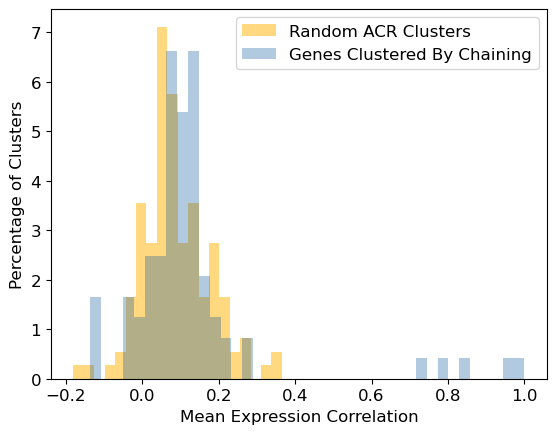

In [18]:
import matplotlib.pyplot as plt

plt.hist(random_correlations_from_acrs, bins = 20, color="#FFB302", alpha=0.5, label='Random ACR Clusters', density = True)

plt.hist(gset_correlations, bins = 40, color="#00529b", alpha=0.3, label='Genes Clustered By Chaining', density = True)
plt.legend(fontsize = 12)
# plt.title("Mean Expression Correlation of ACR Clusters")
plt.ylabel("Percentage of Clusters", fontsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Mean Expression Correlation", fontsize=12)
plt.savefig("../../../Plots/expression_DAPv1_clustered_local_one.png", dpi = 300)


Text(0.5, 0, 'Mean Expression Correlation')

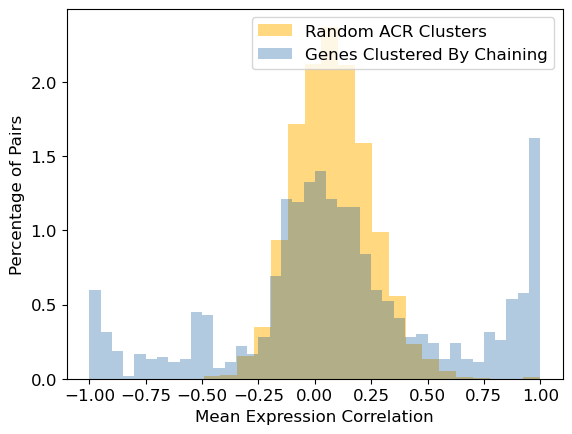

In [27]:
import matplotlib.pyplot as plt

plt.hist(all_correlations_random, bins = 20, color="#FFB302", alpha=0.5, label='Random ACR Clusters', density = True)

plt.hist(all_gset_correlations, bins = 40, color="#00529b", alpha=0.3, label='Genes Clustered By Chaining', density = True)
plt.legend(fontsize = 12)
# plt.title("Mean Expression Correlation of ACR Clusters")
plt.ylabel("Percentage of Pairs", fontsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Mean Expression Correlation", fontsize=12)
# plt.savefig("../../../Plots/expression_DAPv1_clustered_local_one.png", dpi = 300)